In [1025]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1026]:
import logging
import pypsa
import os.path

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import sys

In [1027]:
# running the jupyter notebook on the compute nodes doesnt build the path as expected, you have to manually do this
import IPython

working_directory = os.path.dirname(IPython.extract_module_locals()[1]['__vsc_ipynb_file__'])
os.chdir(working_directory)


In [1028]:

# from make_summary import assign_carriers
from _helpers import configure_logging, mock_snakemake
from constants import PLOT_COST_UNITS, PLOT_CAP_UNITS,PLOT_SUPPLY_UNITS
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
from plot_network import plot_cost_map, plot_map, plot_energy_map
from _plot_utilities import fix_network_names_colors, rename_techs

logger = logging.getLogger(__name__)


In [1029]:
PLANNING_YEAR = 2060
snakemake = mock_snakemake(
    "plot_network",
    snakefile_path=os.path.abspath("../"),
    opts="ll",
    topology="current+FCG",
    pathway="exp175",
    planning_horizons=PLANNING_YEAR,
    heating_demand="positive",
)

configure_logging(snakemake, logger=logger)
config = snakemake.config
tech_colors = config["plotting"]["tech_colors"]


ntw_path = snakemake.input.network

# ntw_path = f"/home/ivanra/documents/PyPSA-China-PIK/results/version-0325.175.1H/postnetworks/positive/postnetwork-ll-current+Neighbor-exponential175-{PLANNING_YEAR}.nc"
# ntw_path = f"/home/ivanra/downloads/PaperResultsXiaowei_networks/postnetwork-ll-current+Neighbor-exponential175-{PLANNING_YEAR}.nc"
n = pypsa.Network(ntw_path)

2025-01-31 12:59:30,485 - _helpers.py - INFO - =========== NEW RUN ===========
2025-01-31 12:59:30,485 - _helpers.py - INFO - =========== NEW RUN ===========
2025-01-31 12:59:30,485 - _helpers.py - INFO - =========== NEW RUN ===========
2025-01-31 12:59:30,485 - _helpers.py - INFO - =========== NEW RUN ===========
2025-01-31 12:59:30,485 - _helpers.py - INFO - =========== NEW RUN ===========
2025-01-31 12:59:30,485 - _helpers.py - INFO - =========== NEW RUN ===========
2025-01-31 12:59:30,485 - _helpers.py - INFO - =========== NEW RUN ===========
2025-01-31 12:59:30,485 - _helpers.py - INFO - =========== NEW RUN ===========
2025-01-31 12:59:30,485 - _helpers.py - INFO - =========== NEW RUN ===========
2025-01-31 12:59:30,485 - _helpers.py - INFO - =========== NEW RUN ===========
2025-01-31 12:59:30,485 - _helpers.py - INFO - =========== NEW RUN ===========
2025-01-31 12:59:30,485 - _helpers.py - INFO - =========== NEW RUN ===========
2025-01-31 12:59:30,485 - _helpers.py - INFO - =====

Index(['Ahai spillage', 'Baihetan spillage', 'Changzhou spillage',
       'Dongfeng spillage', 'Dongjing spillage', 'Ertan spillage',
       'Gezhouba spillage', 'Gongboxia spillage', 'Gongguoqiao spillage',
       'Gongzui spillage', 'Goupitan spillage', 'Guandi spillage',
       'Guangzhao spillage', 'Jinanqiao spillage', 'Jinghong spillage',
       'Jinping1 spillage', 'Jinping2 spillage', 'Jishixia spillage',
       'Laxiwa spillage', 'Lijiaxia spillage', 'Longkaikou spillage',
       'Longyangxia spillage', 'Lubuge spillage', 'Ludila spillage',
       'Luding spillage', 'Manwan spillage', 'Nuozhadu spillage',
       'Pubugou spillage', 'Ruilijiang1 spillage', 'Sanbanxi spillage',
       'Sanxia spillage', 'Shatuo spillage', 'Shenxigou spillage',
       'Shuibuya spillage', 'Silin spillage', 'Tianshengqiao2 spillage',
       'Tongjiezi spillage', 'Wudongde spillage', 'Wujiangdu spillage',
       'Wuqiangxi spillage', 'Xiangjiaba spillage', 'Xiaowan spillage',
       'Xiluodu spilla

In [1030]:
fix_network_names_colors(n, config)

/p/tmp/ivanra/PyPSA-China-PIK/workflow/scripts/_plot_utilities.py:152: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  


In [1031]:
from constants import PROV_NAMES

fix the assign components stoy

In [1032]:
def assign_location(n: pypsa.Network, valid_locations: list = PROV_NAMES):
    """Add the node location name as a column to the component dataframes.
    This is needed because the bus names are of style LOCATION TYPE and cannot be directly grouped
    by province/location otherwise

    Args:
        n (pypsa.Network): the pypsa network object
    """
    for c in n.iterate_components(n.one_port_components | n.branch_components):
        c.df["location"] = c.df.index.str.split(" ", expand=True).get_level_values(0)
        c.df.loc[~c.df.location.isin(valid_locations), "location"] = pd.NA


    # identify links that are not to a region (e.g. hydro)
    for c in n.iterate_components(n.branch_components):
        c.df["plottable"] = c.df.apply(
            lambda row: row.bus0.split(" ")[0] in PROV_NAMES
            and row.bus1.split(" ")[0] in PROV_NAMES,
            axis=1,
        )
    for c in n.iterate_components(n.one_port_components):
        c.df["plottable"] = c.df.location.notna()

# df.dropna(subset=["location"]).shape

# plot map

In [1033]:
from plot_network import plot_cost_map, plot_map

## plot capex
-> todo switch backend to stats

/home/ivanra/.conda/envs/pypsa-china/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


/home/ivanra/.conda/envs/pypsa-china/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/p/tmp/ivanra/PyPSA-China-PIK/workflow/scripts/plot_network.py:178: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/p/tmp/ivanra/PyPSA-China-PIK/workflow/scripts/plot_network.py:338: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


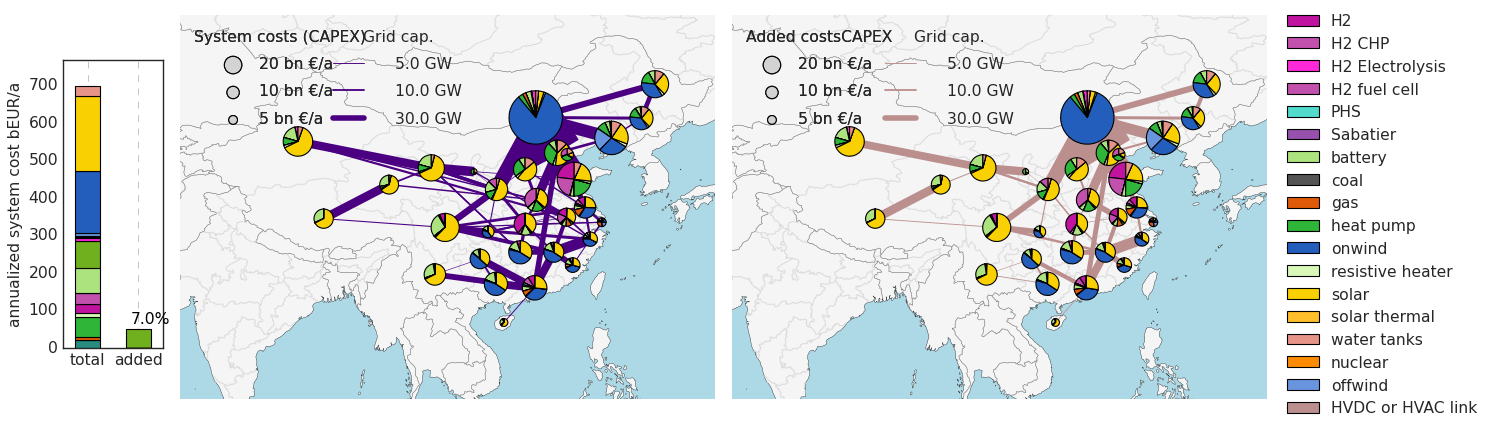

In [1034]:
ax = plot_cost_map(n, int(PLANNING_YEAR), snakemake.config["costs"]["discountrate"], config["plotting"], cost_pannel=True, capex_only=True)

/home/ivanra/.conda/envs/pypsa-china/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/p/tmp/ivanra/PyPSA-China-PIK/workflow/scripts/plot_network.py:178: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/p/tmp/ivanra/PyPSA-China-PIK/workflow/scripts/plot_network.py:338: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


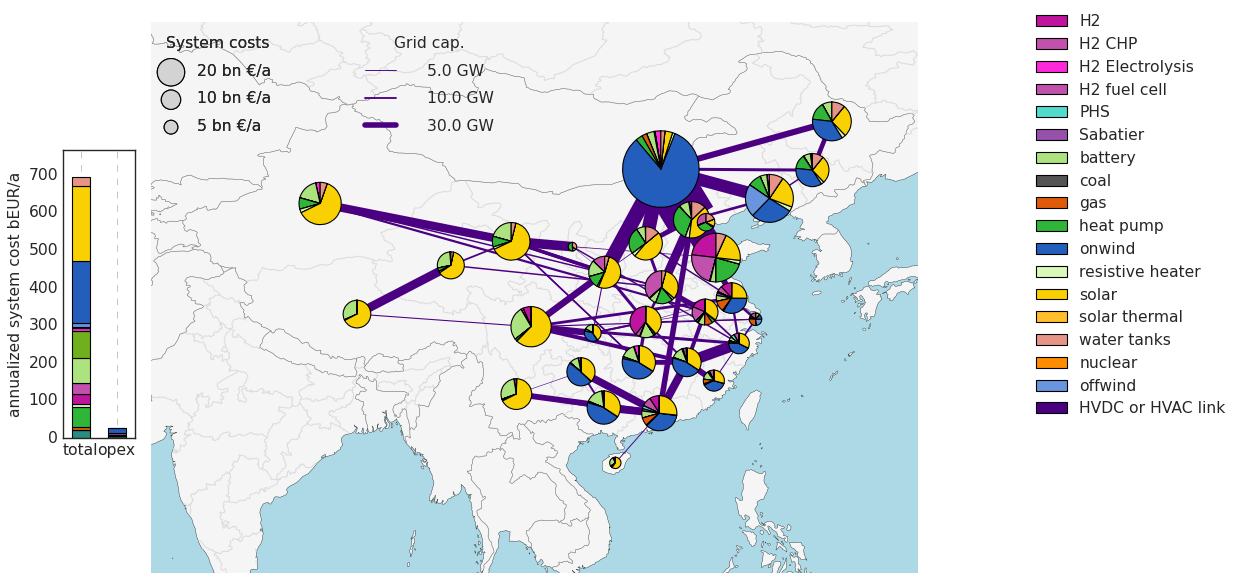

In [1035]:
ax = plot_cost_map(n, int(PLANNING_YEAR), snakemake.config["costs"]["discountrate"], config["plotting"], cost_pannel=True, plot_additions=False, capex_only=False)

## plot electricy generation map

/home/ivanra/.conda/envs/pypsa-china/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/p/tmp/ivanra/PyPSA-China-PIK/workflow/scripts/plot_network.py:496: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/p/tmp/ivanra/PyPSA-China-PIK/workflow/scripts/plot_network.py:457: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


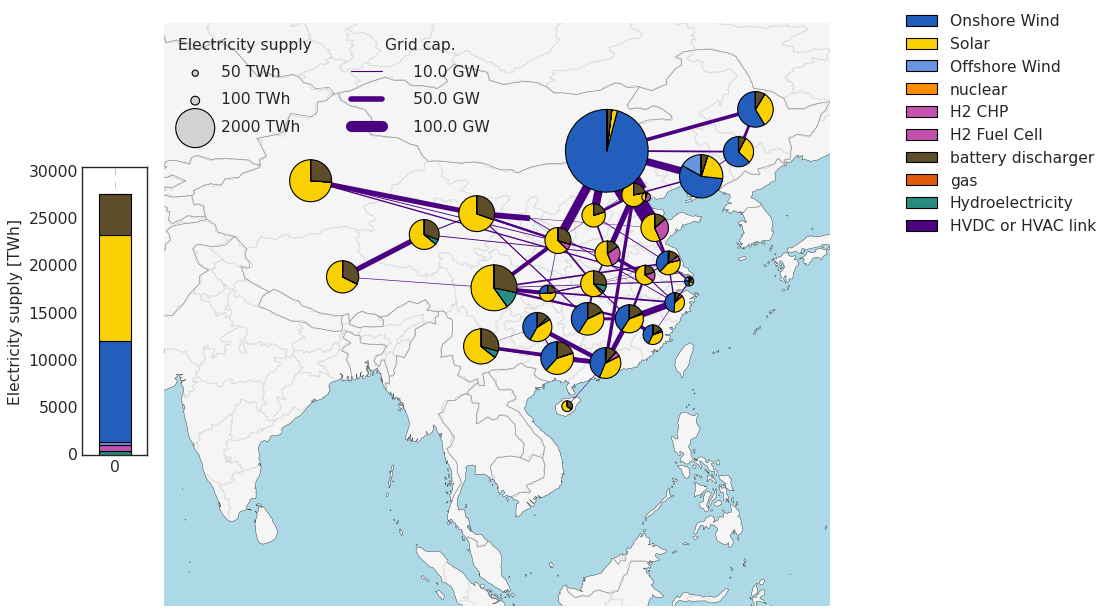

In [1036]:
from plot_network import plot_energy_map
from _plot_utilities import set_plot_style
set_plot_style(
    style_config_file= os.path.abspath("../../config/plotting_styles/network_map.mplstyle"),
    #snakemake.config["plotting"]["network_style_config_file"],
    base_styles=["classic", "seaborn-v0_8-white"],
)
plot_energy_map(n,config["plotting"], carrier="AC", components = ["Generator", "Link"])

/home/ivanra/.conda/envs/pypsa-china/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/p/tmp/ivanra/PyPSA-China-PIK/workflow/scripts/plot_network.py:496: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/p/tmp/ivanra/PyPSA-China-PIK/workflow/scripts/plot_network.py:457: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


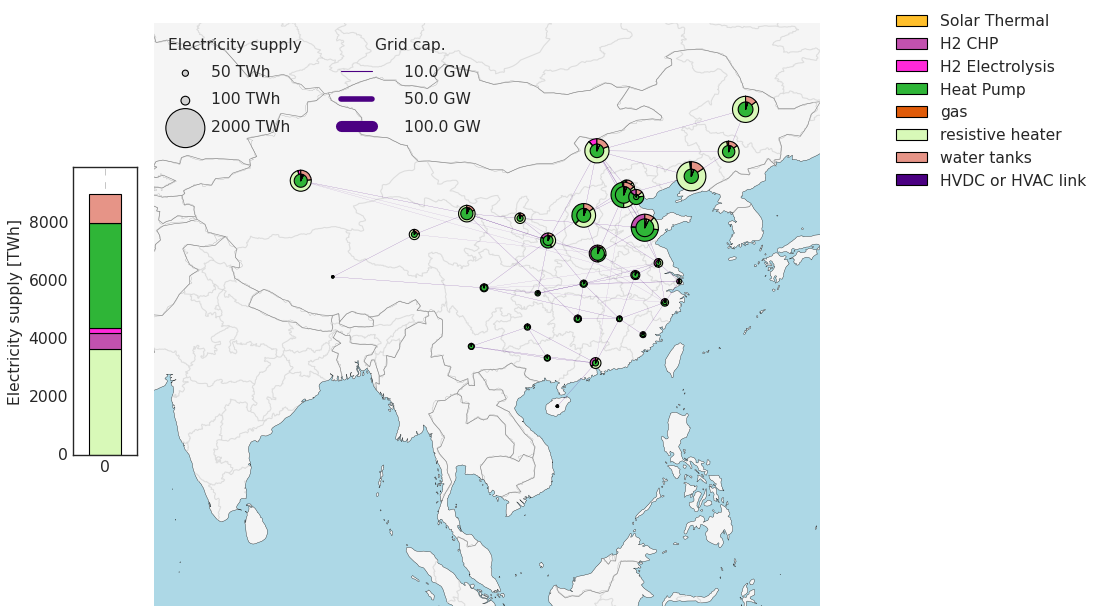

In [1037]:
from plot_network import plot_energy_map
from _plot_utilities import set_plot_style
set_plot_style(
    style_config_file= os.path.abspath("../../config/plotting_styles/network_map.mplstyle"),
    #snakemake.config["plotting"]["network_style_config_file"],
    base_styles=["classic", "seaborn-v0_8-white"],
)
plot_energy_map(n,config["plotting"], carrier="heat", components = ["Generator", "Link"])

In [1038]:
n.links[n.links.carrier=="H2"]["p_nom_opt"].sort_values(ascending=False)

Link
Tianjin-Beijing H2 pipeline reversed     2.021246e+07
Hebei-Beijing H2 pipeline reversed       2.021242e+07
Tianjin-Hebei H2 pipeline reversed       2.021232e+07
Jiangsu-Anhui H2 pipeline reversed       1.044173e+07
Hubei-Henan H2 pipeline reversed         1.014144e+07
                                             ...     
Henan-Qinghai H2 pipeline positive       4.664286e-01
Jiangsu-Sichuan H2 pipeline positive     4.350971e-01
Shanghai-Sichuan H2 pipeline positive    3.875135e-01
Henan-Xinjiang H2 pipeline positive      2.836102e-01
Anhui-Xinjiang H2 pipeline positive      2.508973e-01
Name: p_nom_opt, Length: 154, dtype: float64

In [1039]:
n.links[n.links.carrier=="AC"]["p_nom_opt"].sort_values()

Link
Henan-Shandong                 4.022249
Ningxia-Shaanxi             2108.371550
Hubei-Jiangsu               3000.000455
Guizhou-Yunnan              3142.738163
Anhui-Hubei                 3475.017932
                              ...      
Liaoning-InnerMongolia     66550.029559
InnerMongolia-Shanxi       74828.272880
InnerMongolia-Shaanxi      81173.430607
InnerMongolia-Shandong    146220.161164
Hebei-InnerMongolia       271271.214373
Name: p_nom_opt, Length: 77, dtype: float64

/home/ivanra/.conda/envs/pypsa-china/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


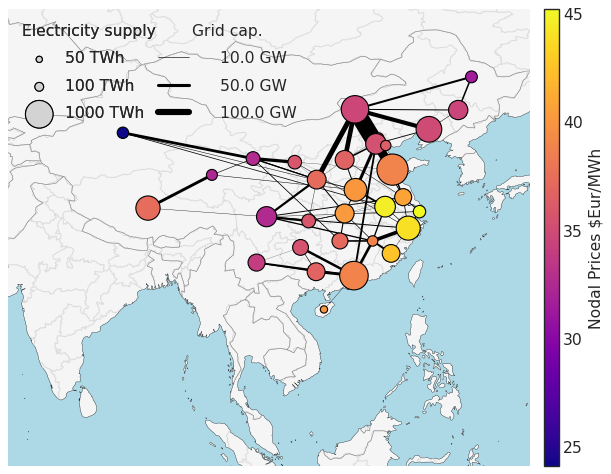

In [1040]:
from plot_network import plot_nodal_prices

plot_nodal_prices(n, config["plotting"], "AC")

/home/ivanra/.conda/envs/pypsa-china/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


<GeoAxes: >

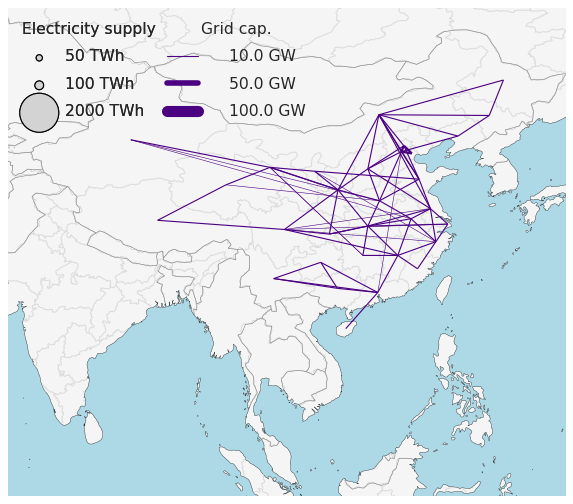

In [1041]:
opts = snakemake.config["plotting"]
plot_h2_ntwk = n.copy()
carrier = "H2"


supply_pies = plot_h2_ntwk.statistics.supply(
        groupby=pypsa.statistics.get_bus_and_carrier, bus_carrier=carrier, comps=["Generator"]
    ).droplevel(0)
# avoid cluttering the plot
plot_h2_ntwk.buses.drop(plot_h2_ntwk.buses.index[plot_h2_ntwk.buses.carrier != carrier], inplace=True)
plot_h2_ntwk.links.drop(
    plot_h2_ntwk.links.index[plot_h2_ntwk.links.carrier != carrier],
    inplace=True,
)

# get all carrier types
carriers_list = supply_pies.index.get_level_values(1).unique()
carriers_list = carriers_list.tolist()

# TODO make line handling nicer
line_lower_threshold = 500.0
line_upper_threshold = 1e4
# Make figure
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(opts["energy_map"]["figsize"])
# get colors
bus_colors = plot_h2_ntwk.carriers.loc[plot_h2_ntwk.carriers.nice_name.isin(carriers_list), "color"]
bus_colors.rename(opts["nice_names"], inplace=True)
# Add the total costs
bus_size_factor = opts["energy_map"]["bus_size_factor"]/1e2
linewidth_factor = opts["energy_map"]["linewidth_factor"]*1e1
edges = pd.concat([plot_h2_ntwk.lines.s_nom_opt, plot_h2_ntwk.links.p_nom_opt])
edge_widths = (
    edges
    .clip(line_lower_threshold, edges.max())
    .replace(line_lower_threshold, 0)
)
preferred_order = pd.Index(opts["preferred_order"])
reordered = preferred_order.intersection(bus_colors.index).append(
    bus_colors.index.difference(preferred_order)
)

plot_map(
    plot_h2_ntwk,
    tech_colors=plot_h2_ntwk.carriers.color,
    edge_widths=edge_widths / linewidth_factor/100,
    bus_colors=bus_colors.loc[reordered],
    bus_sizes=supply_pies / 1,
    edge_colors="indigo",
    ax=ax,
    edge_unit_conv=PLOT_CAP_UNITS,
    bus_unit_conv=PLOT_SUPPLY_UNITS,
    add_legend=False,
    **opts["energy_map"],
)

In [1042]:
nodal_prices = n.statistics.revenue( groupby=pypsa.statistics.get_bus_and_carrier_and_bus_carrier, comps="Load", bus_carrier="AC")/ n.statistics.supply(comps="Load", groupby=pypsa.statistics.get_bus_and_carrier_and_bus_carrier, bus_carrier="AC")*-1
nodal_prices = nodal_prices.droplevel(1).droplevel(1)
nodal_prices

bus
Anhui            inf
Beijing          inf
Chongqing        inf
Fujian           inf
Gansu            inf
Guangdong        inf
Guangxi          inf
Guizhou          inf
Hainan           inf
Hebei            inf
Heilongjiang     inf
Henan            inf
Hubei            inf
Hunan            inf
InnerMongolia    inf
Jiangsu          inf
Jiangxi          inf
Jilin            inf
Liaoning         inf
Ningxia          inf
Qinghai          inf
Shaanxi          inf
Shandong         inf
Shanghai         inf
Shanxi           inf
Sichuan          inf
Tianjin          inf
Tibet            inf
Xinjiang         inf
Yunnan           inf
Zhejiang         inf
Name: objective, dtype: float64

## plot capacity

## plot cost

### Plot nodal prices

## Interactive plot map

In [1043]:

import numpy as np
# make names and link sizes, make sure we only plot AC, DC & statiosn
ac_links = n.links[n.links.carrier == "AC"]
colors = n.links.index.to_series().apply(lambda x: 'black' if 'ext' in x else 'pink')
widths = np.log(n.links.p_nom_opt + 3) / 2
widths[~widths.index.isin(ac_links.index)] = 0
widths[widths.index.str.contains('reversed')] = 0
names = n.links.copy()
names["name"] = names.index.values
names.loc[~names.index.isin(ac_links.index), "p_nom_opt"] = ""
names.loc[~names.index.isin(ac_links.index), "name"] = ""
buses = n.buses.copy()
buses["name"] = buses.apply(lambda x: f"{x.name}" if x.carrier == "AC" or x.carrier=="stations" else "", axis=1)
buses["sizes"] = buses.apply(lambda x:10 if x.carrier == "AC" or x.carrier=="stations" else 0, axis=1)
buses["colors"] = buses.apply(lambda x: "black" if x.carrier == "AC" else "red", axis=1)
buses.carrier.unique()
ax = n.iplot(link_colors=colors, link_widths=widths, link_text = names.p_nom_opt.astype(str) + names.name, bus_text=buses.name, bus_sizes=buses.sizes, bus_colors=buses.colors)

/p/tmp/ivanra/anaconda/ipykernel_3931271/1096144582.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  names.loc[~names.index.isin(ac_links.index), "p_nom_opt"] = ""


### extendable lines

/home/ivanra/.conda/envs/pypsa-china/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


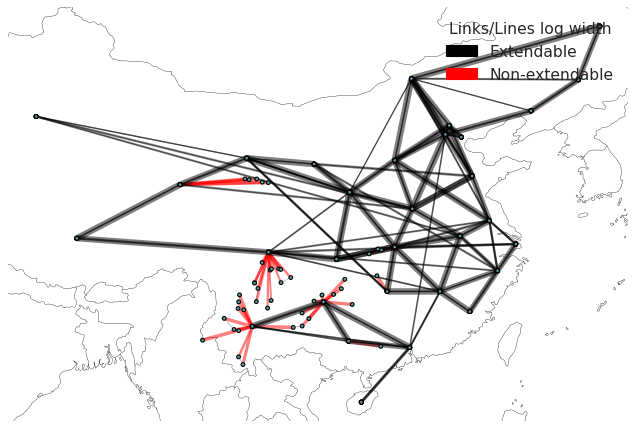

In [1044]:

fig, ax = plt.subplots(1, 1, figsize=(10, 10),subplot_kw={"projection":ccrs.PlateCarree()})
def width(x):
    return np.log10(x/1e6).where(x>1,0)
n.plot(ax = ax,link_colors=n.links.p_nom_extendable.apply(lambda x: "red" if not x else "black"),line_colors=n.lines.s_nom_extendable.apply(lambda x: "red" if not x else "black"), link_widths= width(n.links.p_nom_opt) , line_widths=width(n.lines.s_nom_opt), link_alpha=0.5)
# Create custom legend
import matplotlib.patches as mpatches
extendable_patch = mpatches.Patch(color='black', label='Extendable')
non_extendable_patch = mpatches.Patch(color='red', label='Non-extendable')
ax.legend(handles=[extendable_patch, non_extendable_patch], title = "Links/Lines log width")

# Shadow prices & prices

In [1045]:
from make_summary import make_summaries
summaries = make_summaries({("exp175-paper", PLANNING_YEAR):ntw_path})

INFO:make_summary:Make summary for scenario ('exp175-paper', 2060), using /p/tmp/ivanra/PyPSA-China-PIK/results/v-0.2.0_Debug_overnight_1hr_res/overnight_pthw-exp175_topo-current+FCG_proj-positive/postnetworks/ntwk_2060.nc


Index(['Ahai spillage', 'Baihetan spillage', 'Changzhou spillage',
       'Dongfeng spillage', 'Dongjing spillage', 'Ertan spillage',
       'Gezhouba spillage', 'Gongboxia spillage', 'Gongguoqiao spillage',
       'Gongzui spillage', 'Goupitan spillage', 'Guandi spillage',
       'Guangzhao spillage', 'Jinanqiao spillage', 'Jinghong spillage',
       'Jinping1 spillage', 'Jinping2 spillage', 'Jishixia spillage',
       'Laxiwa spillage', 'Lijiaxia spillage', 'Longkaikou spillage',
       'Longyangxia spillage', 'Lubuge spillage', 'Ludila spillage',
       'Luding spillage', 'Manwan spillage', 'Nuozhadu spillage',
       'Pubugou spillage', 'Ruilijiang1 spillage', 'Sanbanxi spillage',
       'Sanxia spillage', 'Shatuo spillage', 'Shenxigou spillage',
       'Shuibuya spillage', 'Silin spillage', 'Tianshengqiao2 spillage',
       'Tongjiezi spillage', 'Wudongde spillage', 'Wujiangdu spillage',
       'Wuqiangxi spillage', 'Xiangjiaba spillage', 'Xiaowan spillage',
       'Xiluodu spilla

# CO2 emissions

In [1046]:
n.global_constraints

,type,investment_period,carrier_attribute,sense,constant,mu
GlobalConstraint,,,,,,
co2_limit,primary_energy,NaN,co2_emissions,<=,0.0,-1575.452098


<Axes: xlabel='snapshot'>

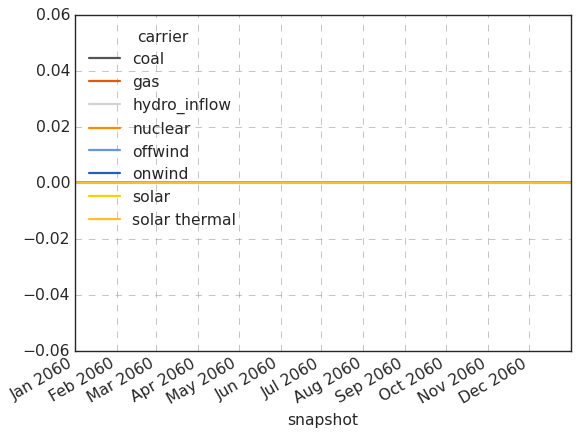

In [1047]:
fig, ax = plt.subplots()
# calc the t resolved CO2 emissions from generators
time_res_emissions = ((n.generators_t.p/ n.generators.efficiency)* n.generators.carrier.map(n.carriers.co2_emissions)).T.groupby(n.generators.carrier).sum()
colors = time_res_emissions.T.columns.map(tech_colors).fillna("lightgrey")
time_res_emissions.T.plot(ax =ax, color =  colors, legend = True)

Text(0, 0.5, 'cum CO2 emissions [t]')

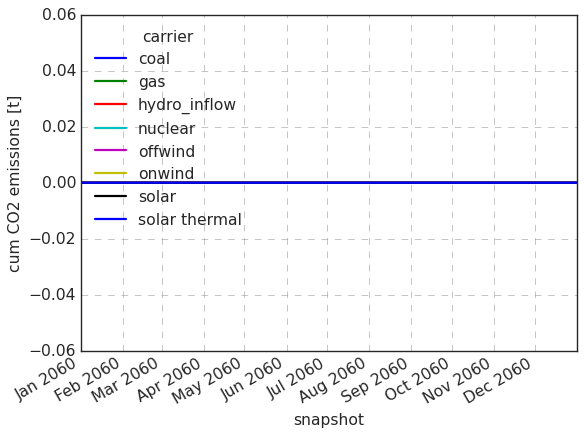

In [1048]:
gen_emissions = ((n.generators_t.p/ n.generators.efficiency)* n.generators.carrier.map(n.carriers.co2_emissions)).T.groupby(n.generators.carrier).sum().T.cumsum()
fig, ax = plt.subplots()
gen_emissions.where(gen_emissions>=0).dropna(axis=1, how="all").plot(ax=ax)
ax.set_ylabel("cum CO2 emissions [t]")


Overnight model does not have CO2 capture or biomass stores, skipped


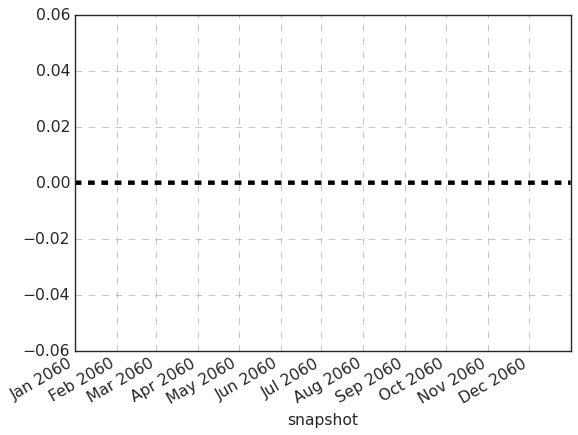

In [1049]:
try:
    fig, ax = plt.subplots()
    # calc the t resolved CO2 emissions from generators
    ((n.generators_t.p/ n.generators.efficiency)* n.generators.carrier.map(n.carriers.co2_emissions)).T.groupby(n.generators.carrier).sum().sum().T.cumsum().plot(ax =ax, label = "CO2 emissions (cum)", lw=4, c ="black", ls = "--")
    n.stores_t.e.T.groupby(n.stores.carrier).sum().loc[["CO2","H2", "CO2 capture", "gas", "biomass"]].T.plot(lw=4, cmap ="jet", ax =ax)
    ax.legend()
    ax.semilogy()
    ax.set_ylim(1e3,1e10)
    ax.set_ylabel("carrier stock")
except KeyError:
    print("Overnight model does not have CO2 capture or biomass stores, skipped")

## CO2 capture
! beware the store is the difference :)

In [1050]:
try:
    stores = n.stores_t.e.T.groupby(n.stores.carrier).sum()
    diff = stores.iloc[:, -1] -stores.iloc[:, 0]
    co2_cap = stores.iloc[:, -1].loc[["CO2 capture"]].sum()
    co2_cap
except KeyError:
    print("Overnight model does not have CO2 capture or biomass stores, skipped")


Overnight model does not have CO2 capture or biomass stores, skipped


<Axes: xlabel='snapshot'>

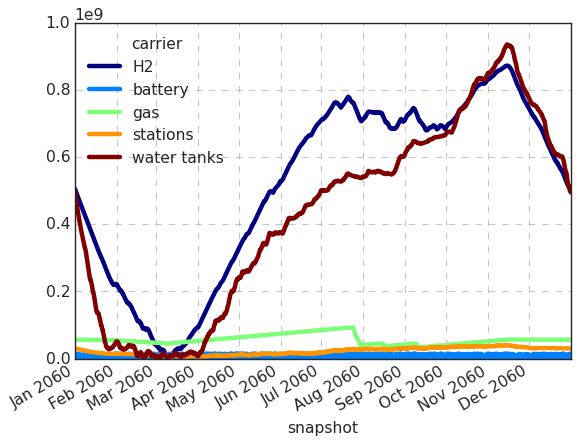

In [1051]:
n.stores_t.e.T.groupby(n.stores.carrier).sum().T.plot(lw=4, cmap ="jet")

# plot time series

In [1052]:
from plot_time_series import plot_energy_balance

INFO:root:        color
Load  #110d63
INFO:plot_time_series:Index(['H2 CHP', 'Hydroelectricity', 'Offshore Wind', 'Onshore Wind', 'Solar',
       'Battery', 'nuclear', 'H2 Fuel Cell', 'Pumped Hydro Storage'],
      dtype='object', name='carrier')
INFO:plot_time_series:carrier
H2 CHP                  #c251ae
Hydroelectricity        #298c81
Hydroelectricity        #298c81
Offshore Wind           #6895dd
Offshore Wind           #6895dd
Onshore Wind            #235ebc
Onshore Wind            #235ebc
Solar                   #f9d002
Solar                   #f9d002
Battery                 #ace37f
Battery                 #ace37f
nuclear                 #ff8c00
H2 Fuel Cell            #c251ae
H2 Fuel Cell            #c251ae
Pumped Hydro Storage    #51dbcc
Pumped Hydro Storage    #51dbcc
Name: color, dtype: object
/home/ivanra/.conda/envs/pypsa-china/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1798: UserWarning: Attempting to set identical low and high ylims makes transforma

Text(0.5, 1.0, 'Electricity Balance')

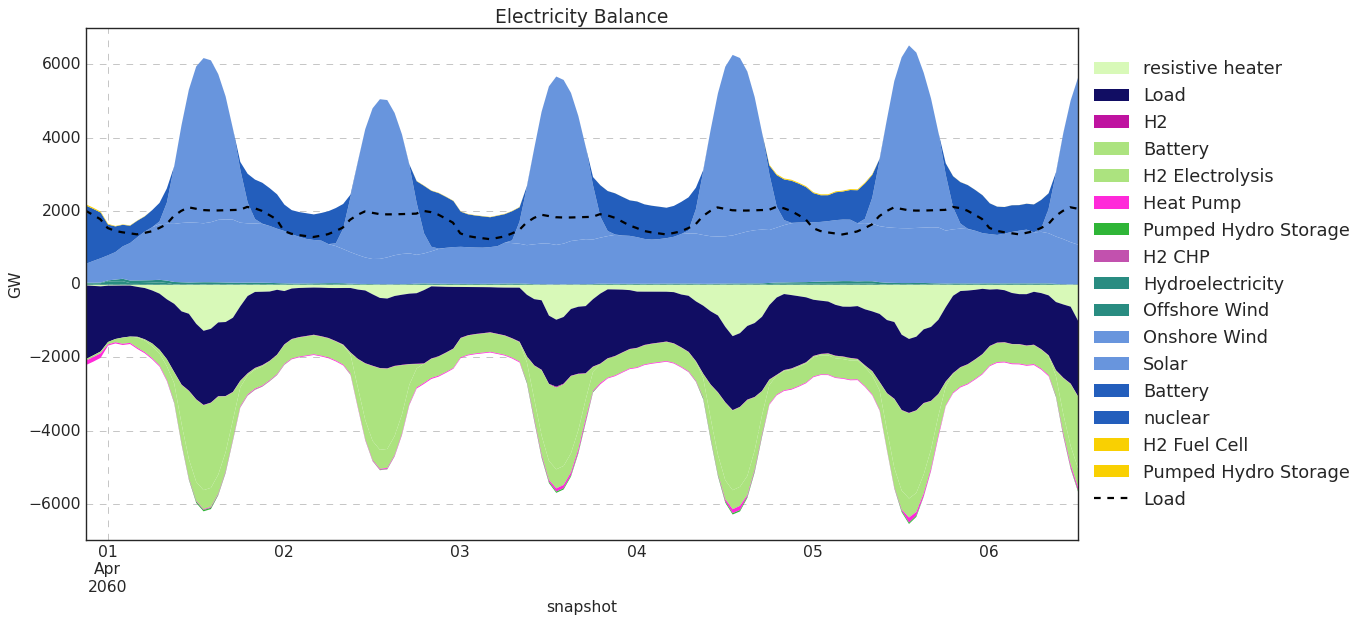

In [1053]:
ax = plot_energy_balance(n, config["plotting"], start_date=f"{PLANNING_YEAR}-03-31 21:00", end_date=f"{PLANNING_YEAR}-04-06 12:00:00")
ax.grid(axis='y')
ax.set_title("Electricity Balance")

INFO:root:        color
Load  #110d63
INFO:plot_time_series:Index(['H2 CHP', 'resistive heater', 'H2 Electrolysis', 'Heat Pump',
       'Solar Thermal', 'water tanks'],
      dtype='object', name='carrier')
INFO:plot_time_series:carrier
H2 CHP              #c251ae
resistive heater    #d8f9b8
H2 Electrolysis     #ff29d9
Heat Pump           #2fb537
Heat Pump           #2fb537
Solar Thermal       #ffbf2b
Solar Thermal       #ffbf2b
water tanks         #e69487
Name: color, dtype: object
/home/ivanra/.conda/envs/pypsa-china/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1798: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, None)


Text(0.5, 1.0, 'Heat balance')

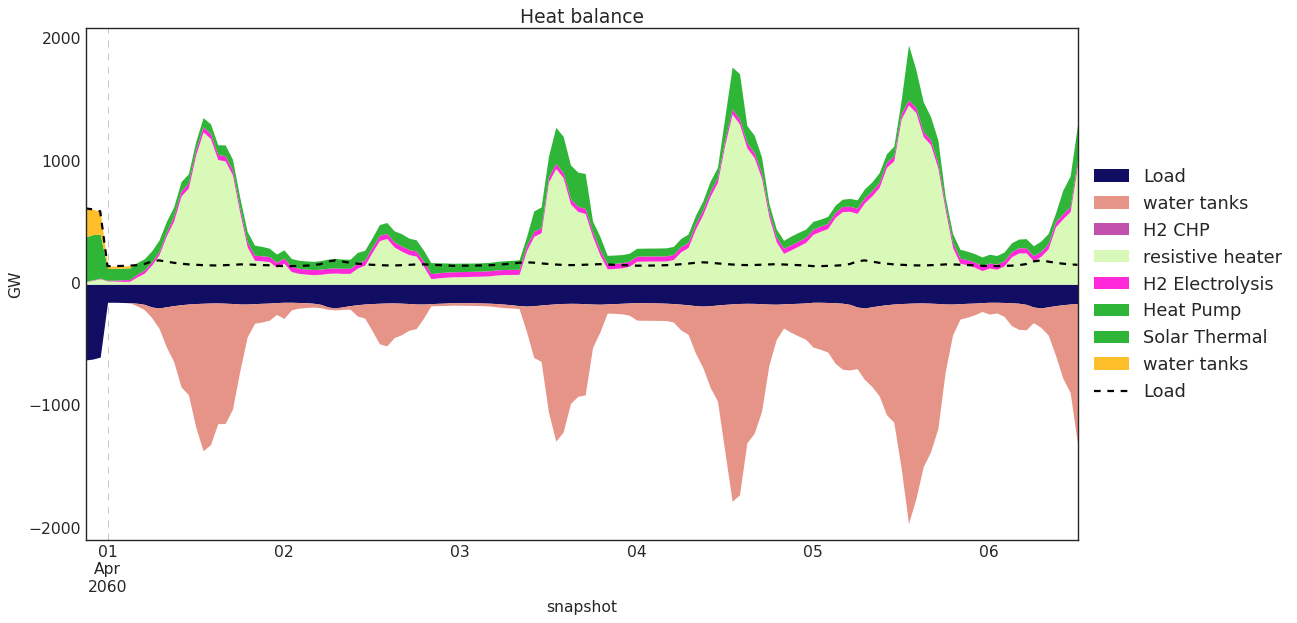

In [1054]:
ax = plot_energy_balance(n, config["plotting"], start_date=f"{PLANNING_YEAR}-03-31 21:00", end_date=f"{PLANNING_YEAR}-04-06 12:00:00", bus_carrier="heat")
ax.set_title("Heat balance")

INFO:root:        color
Load  #110d63
INFO:plot_time_series:Index(['H2 CHP', 'Hydroelectricity', 'Offshore Wind', 'Onshore Wind', 'Solar',
       'Battery', 'nuclear', 'H2 Fuel Cell', 'Pumped Hydro Storage'],
      dtype='object', name='carrier')
INFO:plot_time_series:carrier
H2 CHP                  #c251ae
Hydroelectricity        #298c81
Hydroelectricity        #298c81
Offshore Wind           #6895dd
Offshore Wind           #6895dd
Onshore Wind            #235ebc
Onshore Wind            #235ebc
Solar                   #f9d002
Solar                   #f9d002
Battery                 #ace37f
Battery                 #ace37f
nuclear                 #ff8c00
H2 Fuel Cell            #c251ae
H2 Fuel Cell            #c251ae
Pumped Hydro Storage    #51dbcc
Pumped Hydro Storage    #51dbcc
Name: color, dtype: object
/home/ivanra/.conda/envs/pypsa-china/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1798: UserWarning: Attempting to set identical low and high ylims makes transforma

Text(0.5, 1.0, 'Electricity Balance')

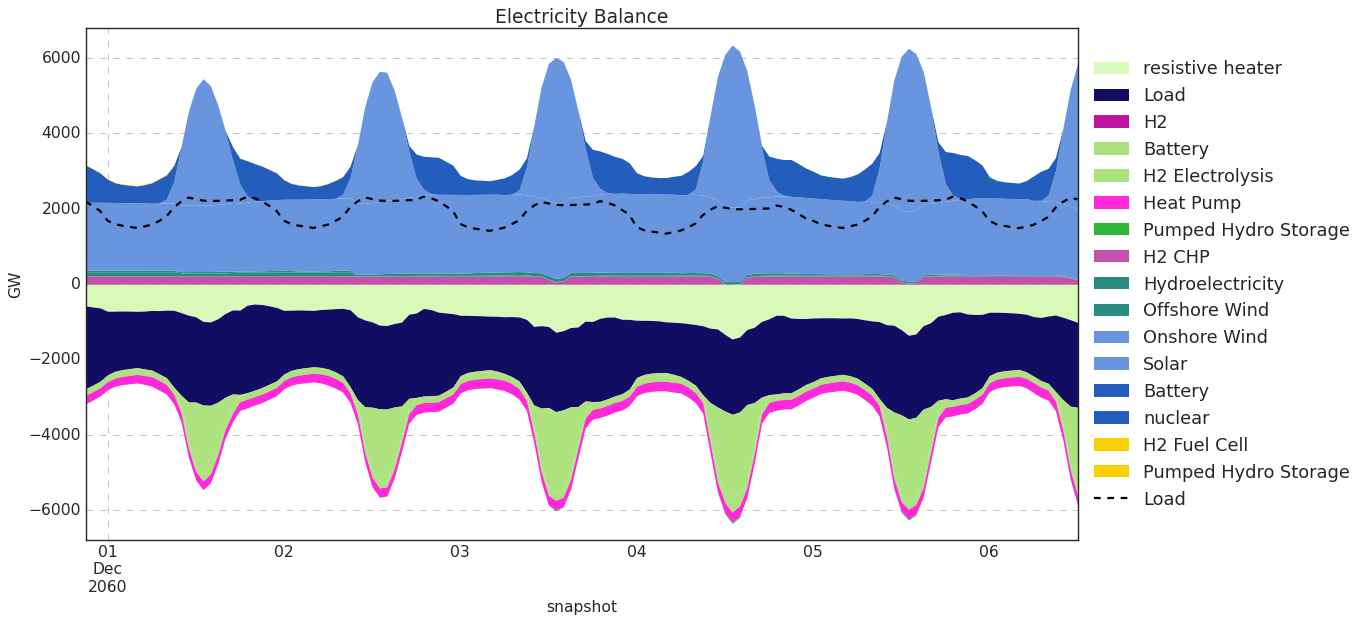

In [1055]:
ax = plot_energy_balance(n, config["plotting"], start_date=f"{PLANNING_YEAR}-11-30 21:00", end_date=f"{PLANNING_YEAR}-12-06 12:00:00")
ax.grid(axis='y')
ax.set_title("Electricity Balance")

INFO:root:        color
Load  #110d63
INFO:plot_time_series:Index(['H2 CHP', 'resistive heater', 'H2 Electrolysis', 'Heat Pump',
       'Solar Thermal', 'water tanks'],
      dtype='object', name='carrier')
INFO:plot_time_series:carrier
H2 CHP              #c251ae
resistive heater    #d8f9b8
H2 Electrolysis     #ff29d9
Heat Pump           #2fb537
Heat Pump           #2fb537
Solar Thermal       #ffbf2b
Solar Thermal       #ffbf2b
water tanks         #e69487
Name: color, dtype: object
/home/ivanra/.conda/envs/pypsa-china/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1798: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, None)


Text(0.5, 1.0, 'Heat balance')

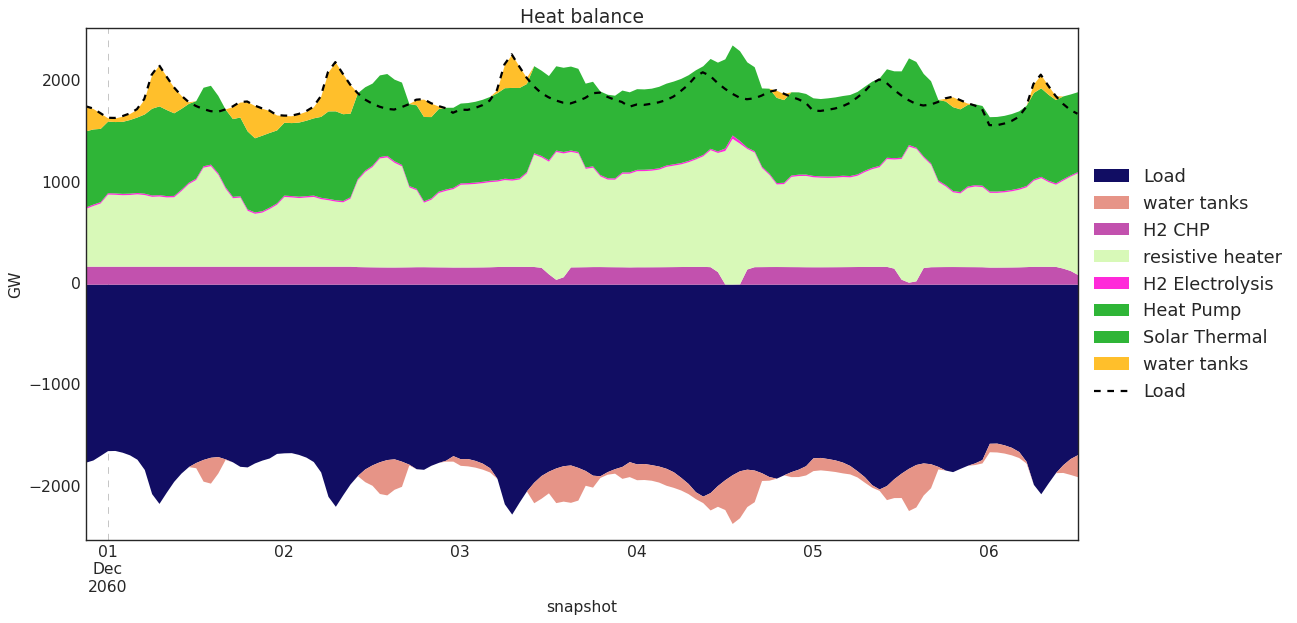

In [1056]:
ax = plot_energy_balance(n, config["plotting"], start_date=f"{PLANNING_YEAR}-11-30 21:00", end_date=f"{PLANNING_YEAR}-12-06 12:00:00", bus_carrier="heat")
ax.set_title("Heat balance")

INFO:root:        color
Load  #110d63
INFO:plot_time_series:Index(['H2 CHP', 'resistive heater', 'H2 Electrolysis', 'Heat Pump',
       'Solar Thermal', 'water tanks'],
      dtype='object', name='carrier')
INFO:plot_time_series:carrier
H2 CHP              #c251ae
resistive heater    #d8f9b8
H2 Electrolysis     #ff29d9
Heat Pump           #2fb537
Heat Pump           #2fb537
Solar Thermal       #ffbf2b
Solar Thermal       #ffbf2b
water tanks         #e69487
Name: color, dtype: object


/home/ivanra/.conda/envs/pypsa-china/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1798: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, None)


Text(0.5, 1.0, 'Heat balance')

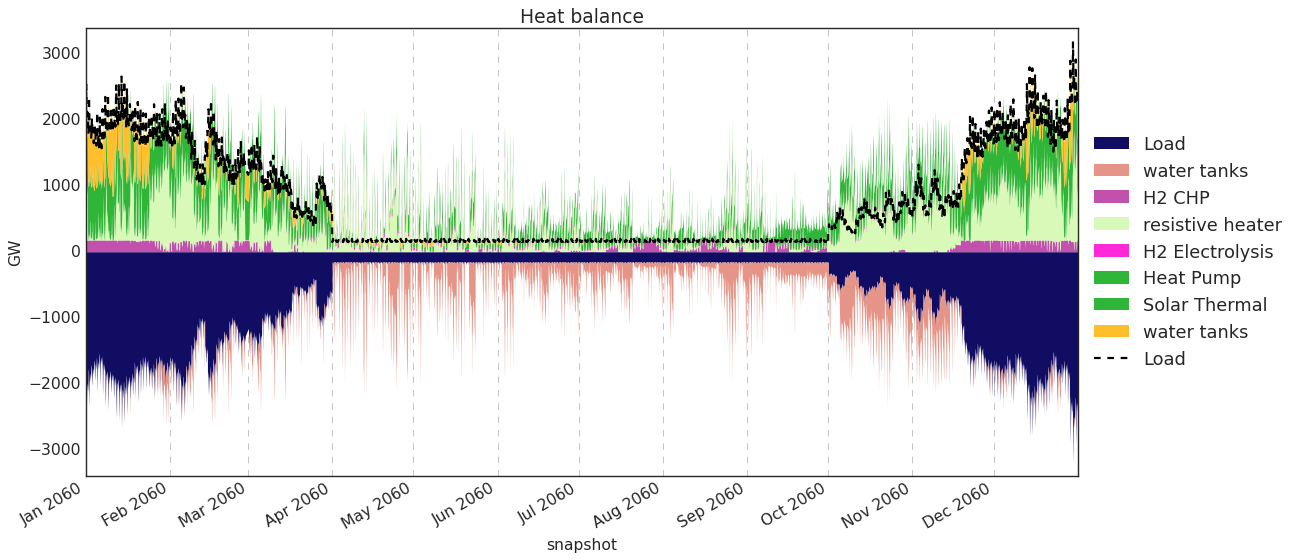

In [1057]:
ax = plot_energy_balance(n, config["plotting"], start_date=f"{PLANNING_YEAR}-01-01 00:00", end_date=f"{PLANNING_YEAR}-12-31 23:00:00", bus_carrier="heat")
ax.set_title("Heat balance")

Text(0, 0.5, 'EnergyDemand / GW')

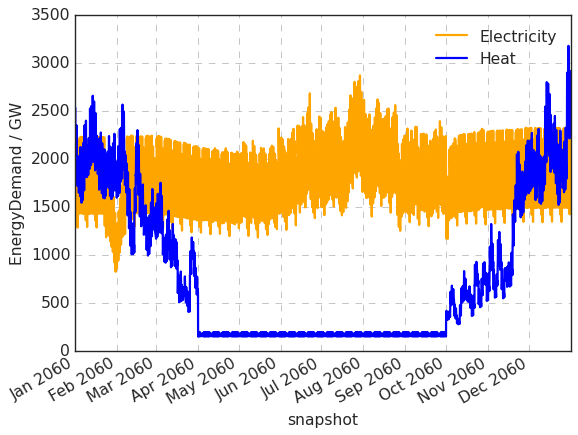

In [1058]:
fix, ax = plt.subplots()
ds_AC = n.statistics.withdrawal(bus_carrier="AC", aggregate_time=False).loc[("Load", "-")]/1e3
ds_heat = n.statistics.withdrawal(bus_carrier="heat", aggregate_time=False).loc[("Load", "-")]/1e3
ds_AC.plot(ax=ax, label="Electricity",  c="orange")
ds_heat.plot(ax=ax, label="Heat", c = "blue")
ax.legend()
ax.set_ylabel("EnergyDemand / GW")

### Plot cap factors time series

In [1059]:
capacity_factors = n.statistics.capacity_factor(aggregate_time=False).loc[["Generator"]].droplevel(0).T

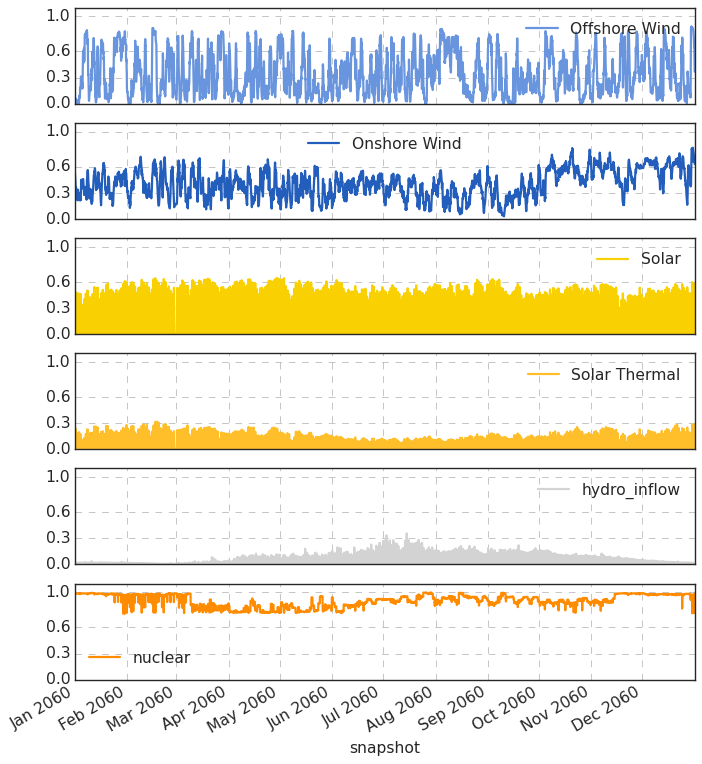

In [1060]:
colors_lowered = {k.lower().rstrip():v for k,v in config["plotting"]["tech_colors"].items()}
cap_colors = {k: colors_lowered.get(k.lower().rstrip(), "lightgrey") for k in [c for c in capacity_factors.columns]}
axes = capacity_factors.dropna(axis=1, how="all").fillna(0).plot(subplots=True, figsize=(10,12), color= cap_colors)
for ax in axes:
    ax.set_ylim([0,1.1])
    ax.set_yticks([0,0.3, 0.6,1])

# Pypsa eur

# Plot time series (dev sandbox)

Text(0, 0.5, 'GW')

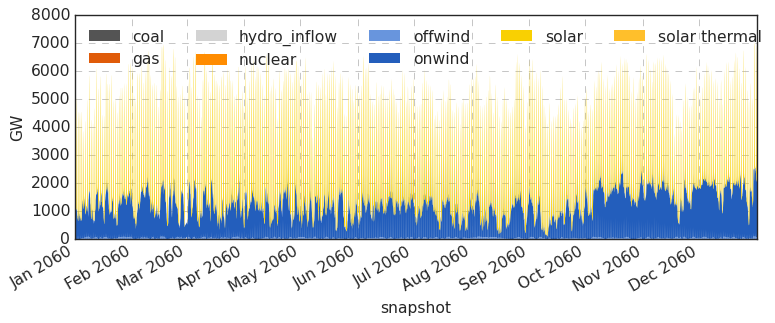

In [1061]:
p_by_carrier = n.generators_t.p.T.groupby(n.generators.carrier).sum().T.div(1e3)
fig, ax = plt.subplots(figsize=(11, 4))

p_by_carrier.plot(
    kind="area",
    ax=ax,
    linewidth=0,
    # cmap="tab20b",
    color = p_by_carrier.columns.map(n.carriers.color),
)

ax.legend(ncol=5, loc="upper left", frameon=False)

ax.set_ylabel("GW")

# ax.set_ylim(0, 80);

# COSTS & prices

In [1062]:
stores_inflow = n.stores_t.p.sum()
h2_stores= stores_inflow.loc[[c for c in stores_inflow.index if c.find("H2 Store")!=-1]]
h2_stores_inflow = h2_stores.where(h2_stores>0,0).sum()
h2_stores_outflow = h2_stores.where(h2_stores<0,0).sum()

# STATS

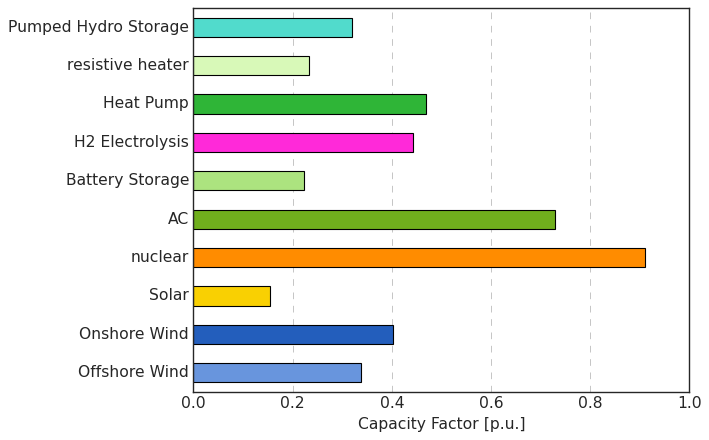

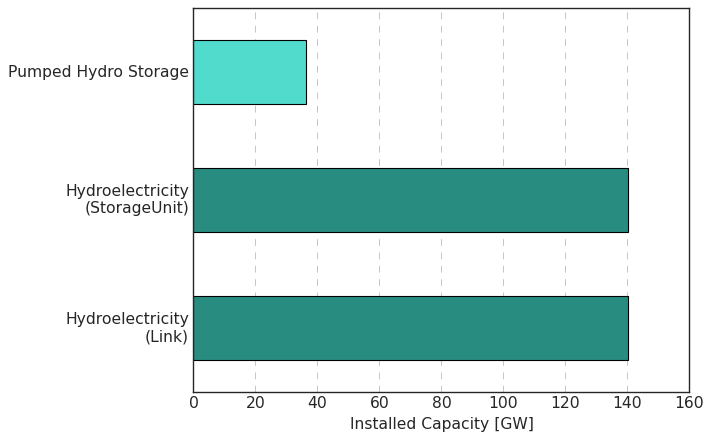

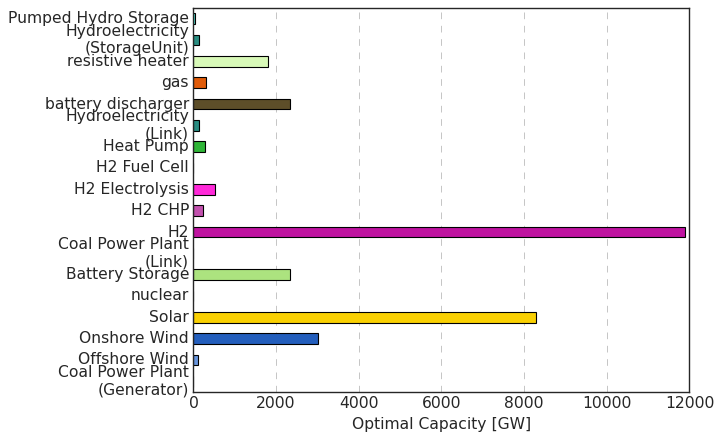

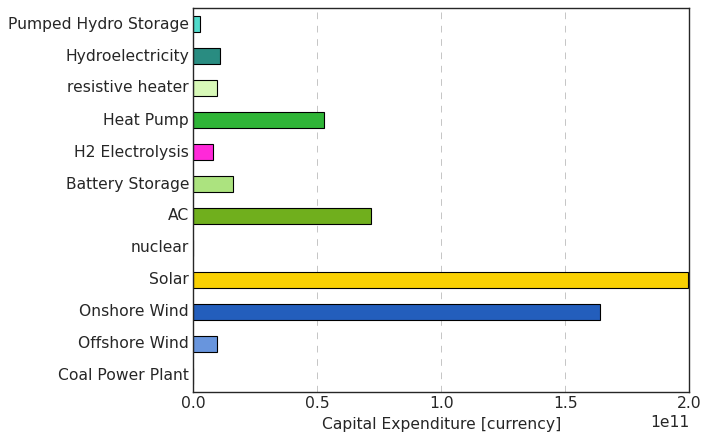

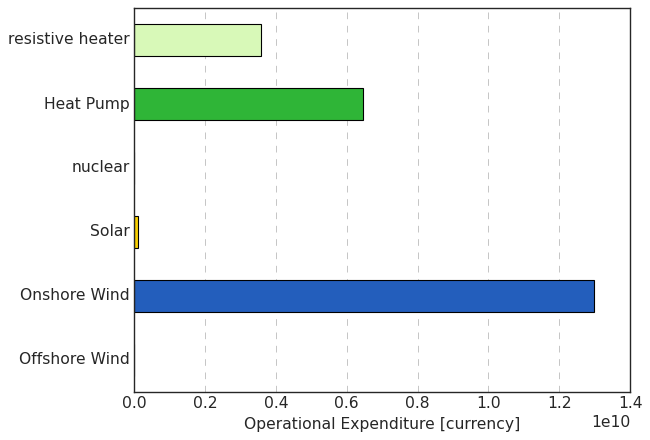

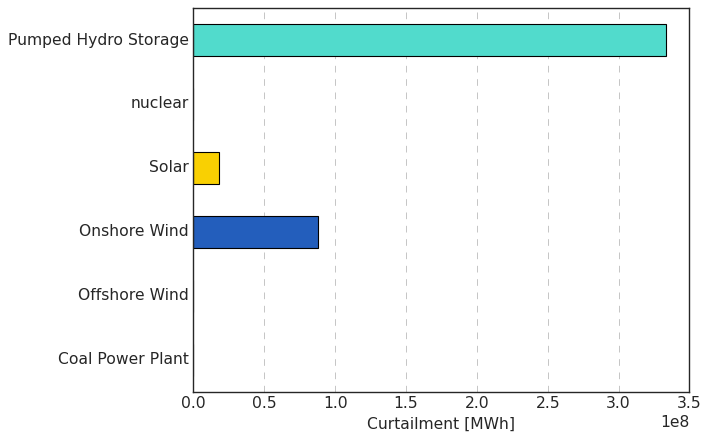

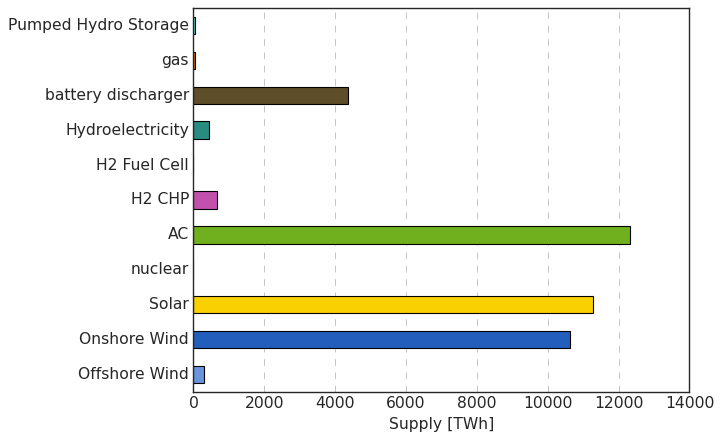

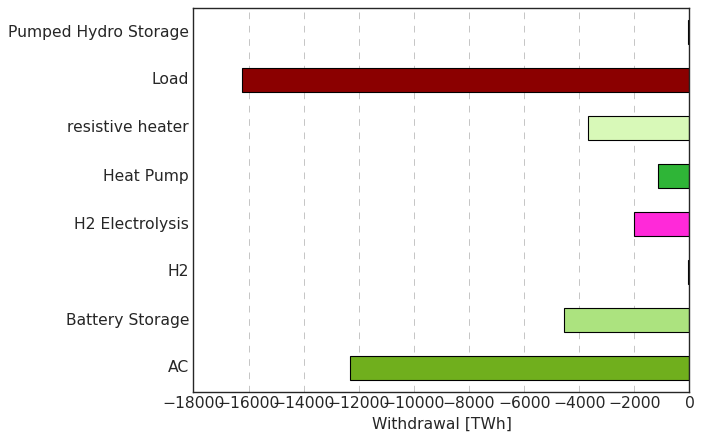

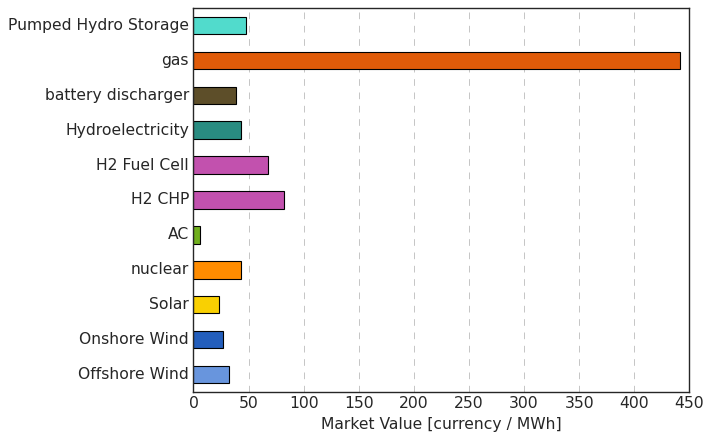

In [1063]:
bus_carrier = "AC"
n.loads.carrier = "load"
n.carriers.loc["load", ["nice_name", "color"]] = "Load", "darkred"
colors = n.carriers.set_index("nice_name").color.where(
    lambda s: s != "", "lightgrey"
)

def rename_index(ds):
    specific = ds.index.map(lambda x: f"{x[1]}\n({x[0]})")
    generic = ds.index.get_level_values("carrier")
    duplicated = generic.duplicated(keep=False)
    index = specific.where(duplicated, generic)
    return ds.set_axis(index)

def plot_static_per_carrier(ds, ax, drop_zero=True):
    if drop_zero:
        ds = ds[ds != 0]
    ds = ds.dropna()
    c = colors[ds.index.get_level_values("carrier")]
    ds = ds.pipe(rename_index)
    label = f"{ds.attrs['name']} [{ds.attrs['unit']}]"
    ds.plot.barh(color=c.values, xlabel=label, ax=ax)
    ax.grid(axis="y")

fig, ax = plt.subplots()
ds = n.statistics.capacity_factor(bus_carrier=bus_carrier).dropna()
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.installed_capacity(bus_carrier=bus_carrier).dropna()
if "Line" in ds.index:
    ds = ds.drop("Line")
ds = ds.drop(("Generator", "Load"), errors="ignore")
ds = ds / 1e3
ds.attrs["unit"] = "GW"
plot_static_per_carrier(ds.abs(), ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.optimal_capacity(bus_carrier=bus_carrier)
if "Line" in ds.index:
    ds = ds.drop("Line")
ds = ds.drop(("Generator", "Load"), errors="ignore")
ds = ds.abs() / 1e3
ds.attrs["unit"] = "GW"
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.capex(bus_carrier=bus_carrier)
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.opex(bus_carrier=bus_carrier)
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.curtailment(bus_carrier=bus_carrier)
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.supply(bus_carrier=bus_carrier)
if "Line" in ds.index:
    ds = ds.drop("Line")
ds = ds / 1e6
ds.attrs["unit"] = "TWh"
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.withdrawal(bus_carrier=bus_carrier)
if "Line" in ds.index:
    ds = ds.drop("Line")
ds = ds / -1e6
ds.attrs["unit"] = "TWh"
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.market_value(bus_carrier=bus_carrier)
plot_static_per_carrier(ds, ax)
plt.show()

In [1064]:
n.statistics.market_value()

component    carrier             
Generator    Offshore Wind            32.490533
             Onshore Wind             26.628880
             Solar                    23.214469
             Solar Thermal            15.375473
             hydro_inflow             18.157628
             nuclear                  43.006943
Link         AC                        5.582016
             Battery Storage           3.573528
             H2                        0.236629
             H2 CHP                   23.553105
             H2 Electrolysis           4.651044
             H2 Fuel Cell             16.962756
             Heat Pump                16.358666
             Hydroelectricity         17.952103
             Sabatier                 62.023595
             battery discharger        0.052461
             gas                     190.635049
             resistive heater          3.583219
             stations                 -0.007067
             water tanks              -0.000252
Load  

In [1065]:
n.statistics.market_value(bus_carrier="AC")

component    carrier             
Generator    Offshore Wind            32.490533
             Onshore Wind             26.628880
             Solar                    23.214469
             nuclear                  43.006943
Link         AC                        5.582016
             Battery Storage                NaN
             H2                             NaN
             H2 CHP                   82.165949
             H2 Electrolysis                NaN
             H2 Fuel Cell             68.034772
             Heat Pump                      NaN
             Hydroelectricity         42.727535
             battery discharger       39.046124
             gas                     441.305962
             resistive heater               NaN
Load         Load                           NaN
StorageUnit  Pumped Hydro Storage     47.449023
dtype: float64

In [1066]:
n.statistics.market_value(groupby=pypsa.statistics.get_carrier_and_bus_carrier)

component    carrier               bus_carrier    
Generator    Offshore Wind         AC                  32.490533
             Onshore Wind          AC                  26.628880
             Solar                 AC                  23.214469
             Solar Thermal         heat                15.375473
             hydro_inflow          stations            18.157628
             nuclear               AC                  43.006943
Link         AC                    AC                   5.582016
             Battery Storage       AC                        NaN
                                   Battery Storage     26.813470
             H2                    AC                        NaN
                                   H2                   0.526242
             H2 CHP                AC                  82.165949
                                   H2                        NaN
                                   heat                42.593397
             H2 Electrolysis       AC  

In [1067]:
n.statistics.market_value(groupby=pypsa.statistics.get_carrier_and_bus_carrier, bus_carrier="AC")

component    carrier               bus_carrier
Generator    Offshore Wind         AC              32.490533
             Onshore Wind          AC              26.628880
             Solar                 AC              23.214469
             nuclear               AC              43.006943
Link         AC                    AC               5.582016
             Battery Storage       AC                    NaN
             H2                    AC                    NaN
             H2 CHP                AC              82.165949
             H2 Electrolysis       AC                    NaN
             H2 Fuel Cell          AC              68.034772
             Heat Pump             AC                    NaN
             Hydroelectricity      AC              42.727535
             battery discharger    AC              39.046124
             gas                   AC             441.305962
             resistive heater      AC                    NaN
Load         Load                  AC 

In [1068]:
n.statistics.supply()

component    carrier             
Generator    Offshore Wind           3.077988e+08
             Onshore Wind            1.063672e+10
             Solar                   1.127099e+10
             Solar Thermal           2.544450e+03
             hydro_inflow            2.357906e+08
             nuclear                 5.636927e+04
Link         AC                      1.232653e+10
             Battery Storage         4.445934e+09
             H2                      2.991271e+09
             H2 CHP                  1.219334e+09
             H2 Electrolysis         1.678849e+09
             H2 Fuel Cell            1.155092e+04
             Heat Pump               3.605667e+09
             Hydroelectricity        6.265495e+08
             Sabatier                8.934416e+07
             battery discharger      4.356108e+09
             gas                     4.520825e+07
             resistive heater        3.650575e+09
             stations                8.903307e+06
             wat

# brownfield

In [1069]:
ds = n.statistics.installed_capacity(bus_carrier=bus_carrier).dropna()

ds = ds[ds != 0]
ds = ds.dropna()
c = colors[ds.index.get_level_values("carrier")]
# ds = ds.pipe(rename_index)
# label = f"{ds.attrs['name']} [{ds.attrs['unit']}]"
# ds.plot.barh(color=c.values, xlabel=label, ax=ax)
# ax.grid(axis="y")
ds

component    carrier             
Link         Hydroelectricity        140322.0
StorageUnit  Hydroelectricity        140322.0
             Pumped Hydro Storage     36390.0
dtype: float64

# Network topology
irrelevant as don't have lines

In [1070]:
n.determine_network_topology()
n.sub_networks["n_branches"] = [
    len(sn.branches()) for sn in n.sub_networks.obj
]
n.sub_networks["n_buses"] = [len(sn.buses()) for sn in n.sub_networks.obj]

n.sub_networks



,carrier,slack_bus,obj,n_branches,n_buses
SubNetwork,,,,,
0,AC,Anhui,<pypsa.components.SubNetwork object at 0x7f773...,0,1
1,AC,Beijing,<pypsa.components.SubNetwork object at 0x7f773...,0,1
2,AC,Chongqing,<pypsa.components.SubNetwork object at 0x7f773...,0,1
3,AC,Fujian,<pypsa.components.SubNetwork object at 0x7f773...,0,1
4,AC,Gansu,<pypsa.components.SubNetwork object at 0x7f773...,0,1
...,...,...,...,...,...
379,battery,Tianjin battery,<pypsa.components.SubNetwork object at 0x7f773...,0,1
380,battery,Tibet battery,<pypsa.components.SubNetwork object at 0x7f773...,0,1
381,battery,Xinjiang battery,<pypsa.components.SubNetwork object at 0x7f773...,0,1


# EXAMPLES